In [1]:
import re
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import cellrank as cr
import seaborn as sns
import matplotlib.cm as cm
import os
import scipy.io
from scipy import sparse
from anndata import AnnData


import matplotlib.pyplot as plt

sc.set_figure_params(dpi=100, color_map='viridis', fontsize=6)
sc.settings.verbosity=2
sc.settings.n_jobs=16
cr.settings.verbosity = 2
scv.settings.verbosity = 3
#sc.logging.print_versions()

stype = "CD8"
oDir = f"./OUT_Fig2/"

if not os.path.exists(oDir):
    os.makedirs(oDir)
#os.chdir(oDir)

In [2]:
adata = sc.read(f"{oDir}/../../data/velo/adata_{stype}.h5ad")

In [4]:
## subset & add reduction
redim1 = pd.read_csv(f"{oDir}/../../data/metaInfo/{stype}_Tex.umap_harmony.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
# subset
flag = np.isin(np.array(adata.obs.miniCluster), np.array(redim1.index))
adata = adata[flag,] 
redim1 = redim1.loc[list(adata.obs.miniCluster), :]
#
adata.obsm['X_UMAP'] = np.array(redim1)

In [5]:
## add colSet
adata.obs["meta.cluster"] = adata.obs["meta.cluster"].astype('category')
color = pd.read_csv(f"{oDir}/../../data/metaInfo/color_meta.cluster_.txt.gz", compression="gzip", sep="\t", header=None, index_col=0)
color_used = list(color.loc[adata.obs["meta.cluster"].cat.categories,1])
adata.uns['meta.cluster_colors'] = color_used

In [6]:
adata

AnnData object with n_obs × n_vars = 75308 × 33694
    obs: 'patient', 'libraryID', 'cancerType', 'loc', 'batchV', 'TCR', 'dataset', 'ClusterID', 'dataset.tech', 'cellID.uniq', 'S.Score', 'G2M.Score', 'Phase', 'DIG.Score1', 'score.MALAT1', 'percent.mito', 'miniCluster', 'meta.cluster', 'meta.cluster.coarse', 'ClusterID.harmony', 'cluster.name', 'stype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'meta.cluster_colors'
    obsm: 'X_UMAP'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

# preprocess

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, min_shared_cells=30, log=True)

Filtered out 25970 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [8]:
## clean some genes
ignoreGenes = pd.read_csv(f"{oDir}/../../data/external/all.gene.ignore.df.txt.gz", compression="gzip", sep="\t", header=0, index_col=0)
flag = [not i in list(ignoreGenes['geneSymbol']) for i in list(adata.var.index)]
adata = adata[:,flag]
#
flag = [not bool(re.match('^RP[LS]', i)) for i in adata.var_names]
adata = adata[:,flag]
#
adata = adata[:,adata.var_names != "MALAT1"]

In [9]:
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000, subset=False)

Trying to set attribute `.var` of view, copying.


Extracted 2000 highly variable genes.


# Velocity

In [10]:
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:13)
computing neighbors
    finished (0:00:37) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:37) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
# this step will take a long while
import gc
gc.collect()
#
temp_pre= f"{oDir}/{stype}_Tex.in_process"
if False==os.path.exists(f"{temp_pre}.velo.h5ad.gz"):
    scv.tl.recover_dynamics(adata, var_names='all', n_jobs=64)
    scv.tl.velocity(adata, mode='dynamical')
    adata.write(f"{temp_pre}.velo.h5ad.gz", compression='gzip')
else:
    adata = sc.read(f"{temp_pre}.velo.h5ad.gz", compression='gzip')

recovering dynamics (using 64/64 cores)


  0%|          | 0/6978 [00:00<?, ?gene/s]

/tools/software/Python/Python-3.9.5/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/tools/software/Python/Python-3.9.5/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:40:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:21:36) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [12]:
#### read signature genes
genes = pd.read_csv(f"{oDir}/../../data/metaInfo/signature_genes.txt.gz", compression="gzip", header=None, index_col=None, sep="\t")
genes = list(genes.loc[genes[0]=="CD8.c12.Tex.CXCL13",1])
#
select_genes = list(set(genes) & set(adata.var_names))
adata.var['select_genes'] = [i in select_genes for i in list(adata.var_names)]
adata.var['velocity_genes'] = adata.var['select_genes']

In [13]:
scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, basis="UMAP")

computing velocity graph (using 1/64 cores)


  0%|          | 0/75308 [00:00<?, ?cells/s]

/tools/software/Python/Python-3.9.5/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:01:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:26) --> added
    'velocity_UMAP', embedded velocity vectors (adata.obsm)


saving figure to file ./figures/scvelo_CD8_Tex.pdf


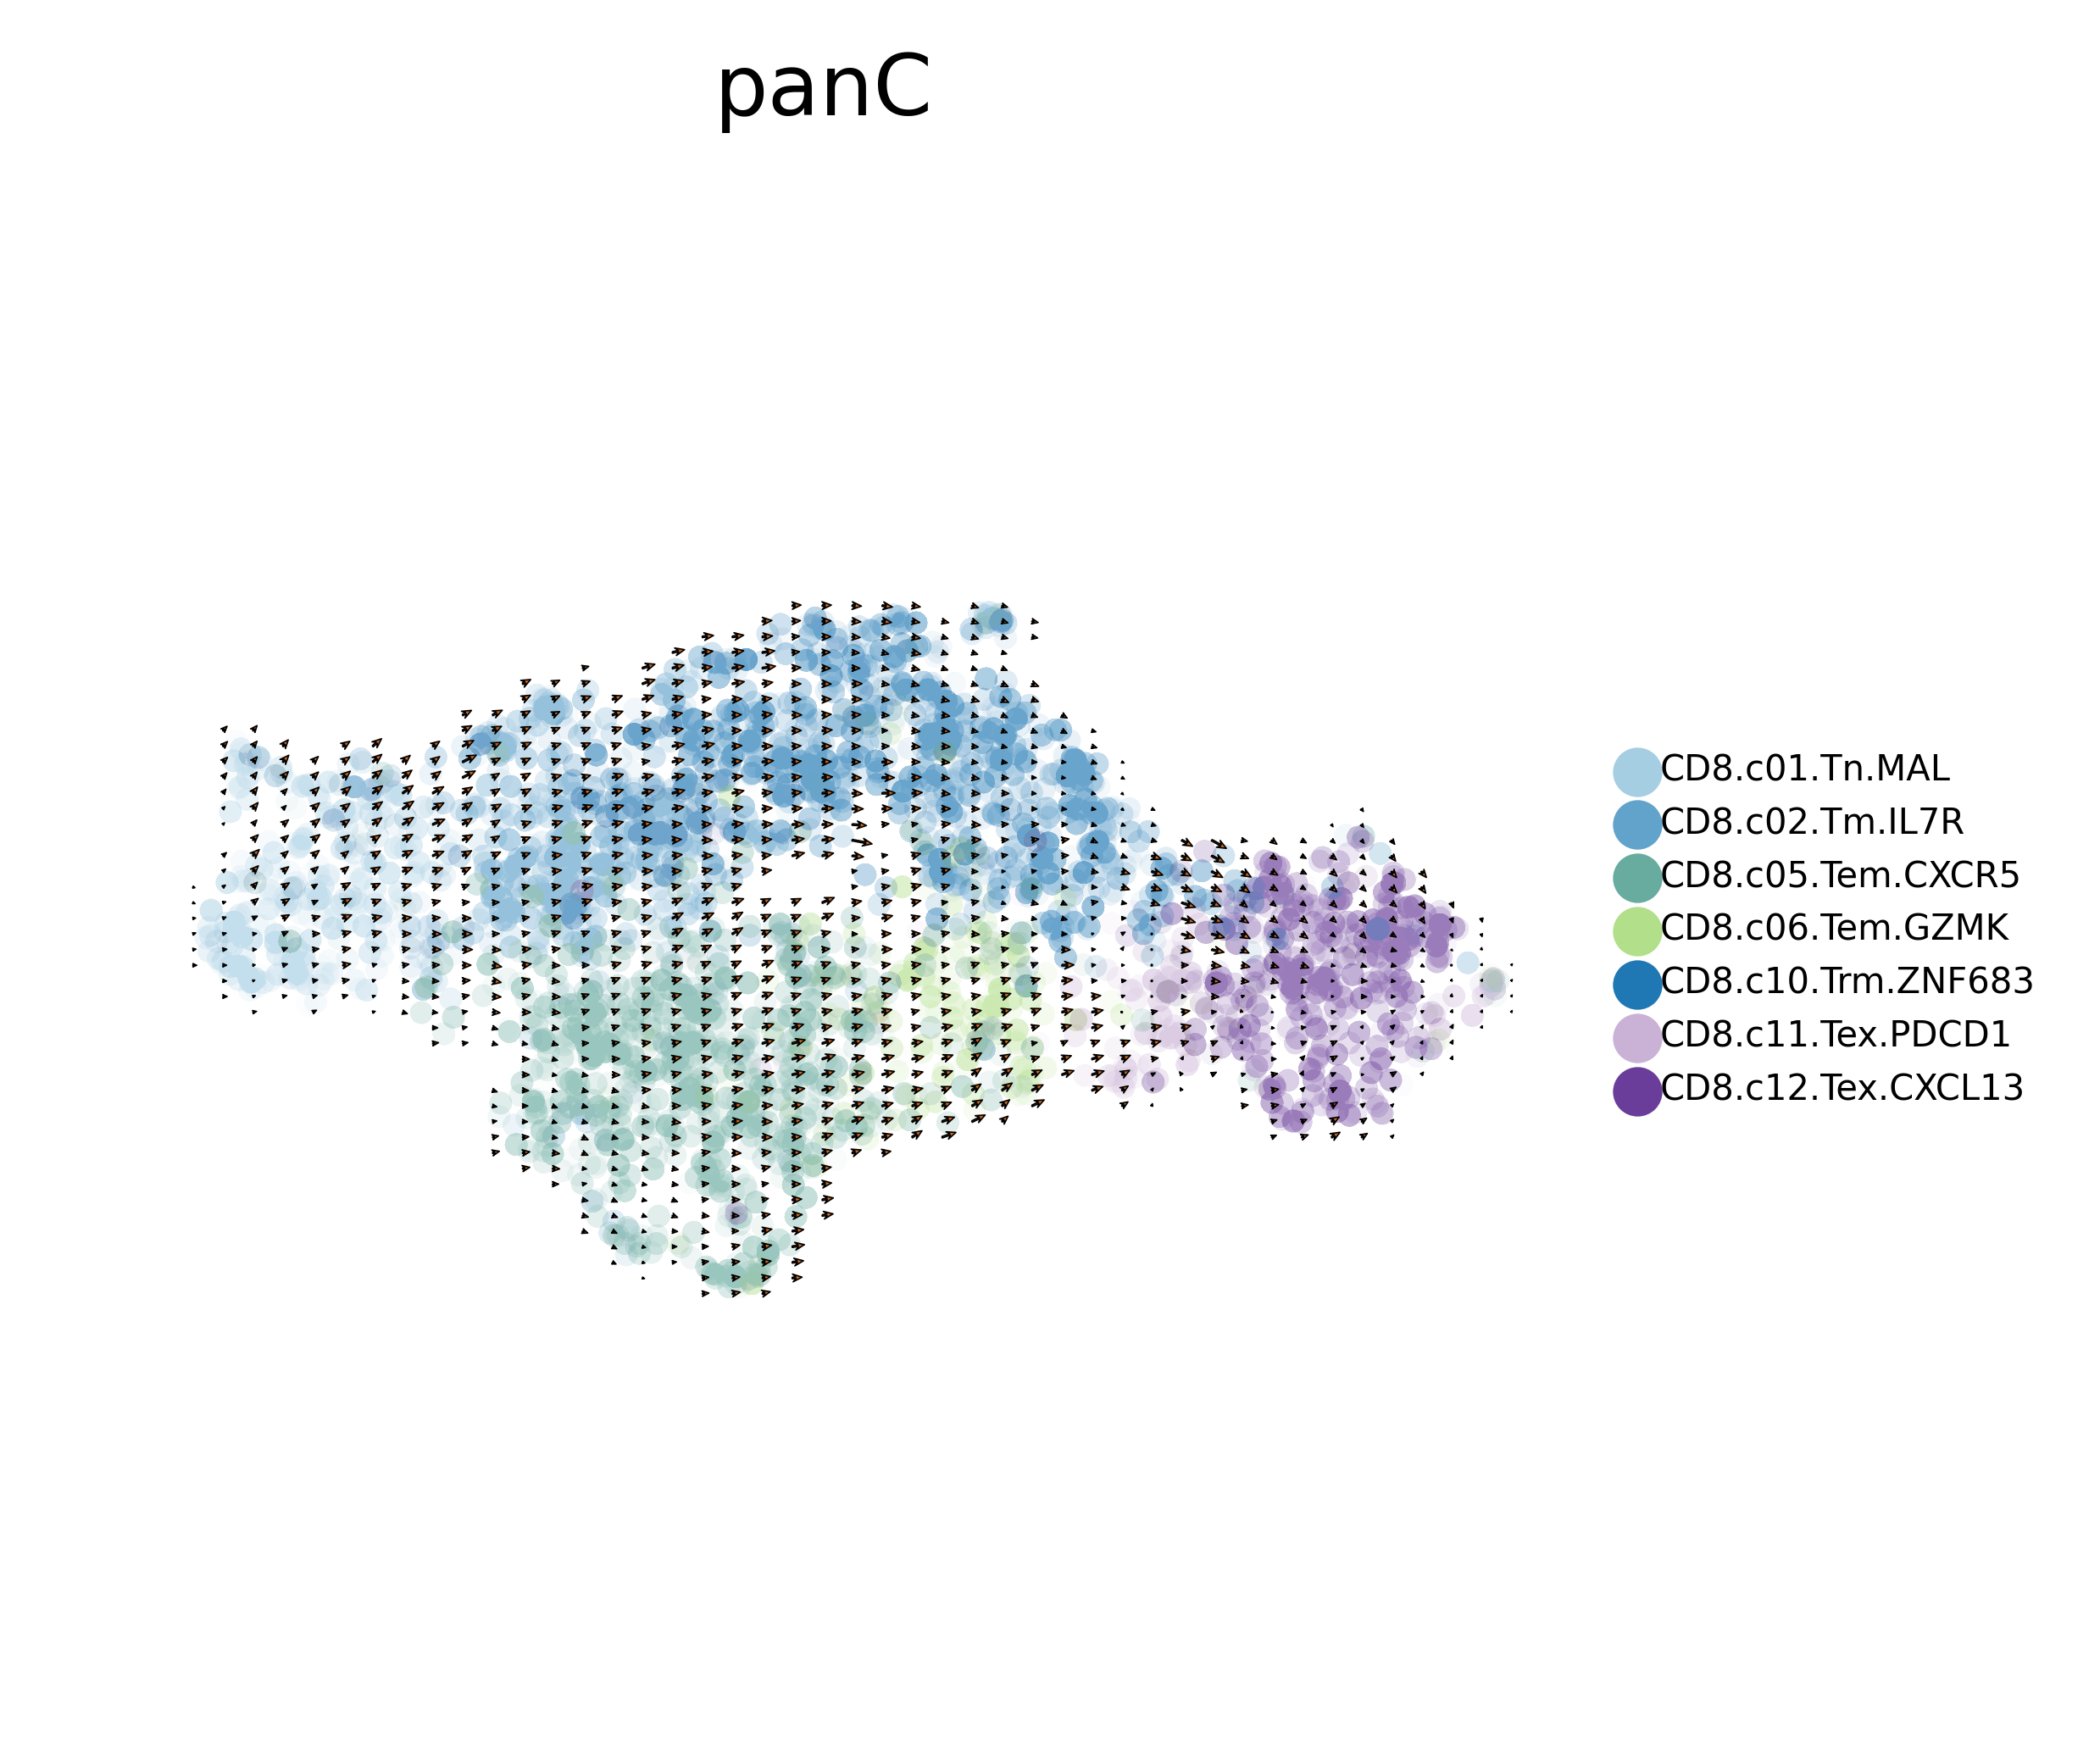

In [14]:
scv.settings.set_figure_params('scvelo', dpi=300, dpi_save=300)
fig, ax = plt.subplots()
ax.set_aspect(1)
scv.pl.velocity_embedding_grid(adata, basis='UMAP',color='meta.cluster', title='panC',
                               arrow_size=1, arrow_length=2, arrow_color="#D2691E",
                               alpha=0.01,
                               density=0.9,
                               legend_loc='right margin',legend_fontsize=5,
                               show=True,
                               save=f"{stype}_Tex.pdf", #figsize=(10,10),
                               xlim=[-10,10],ylim=[-10,10], ax=ax)

saving figure to file ./figures/scvelo_CD8_Tex.FigureS14.UCEC.pdf


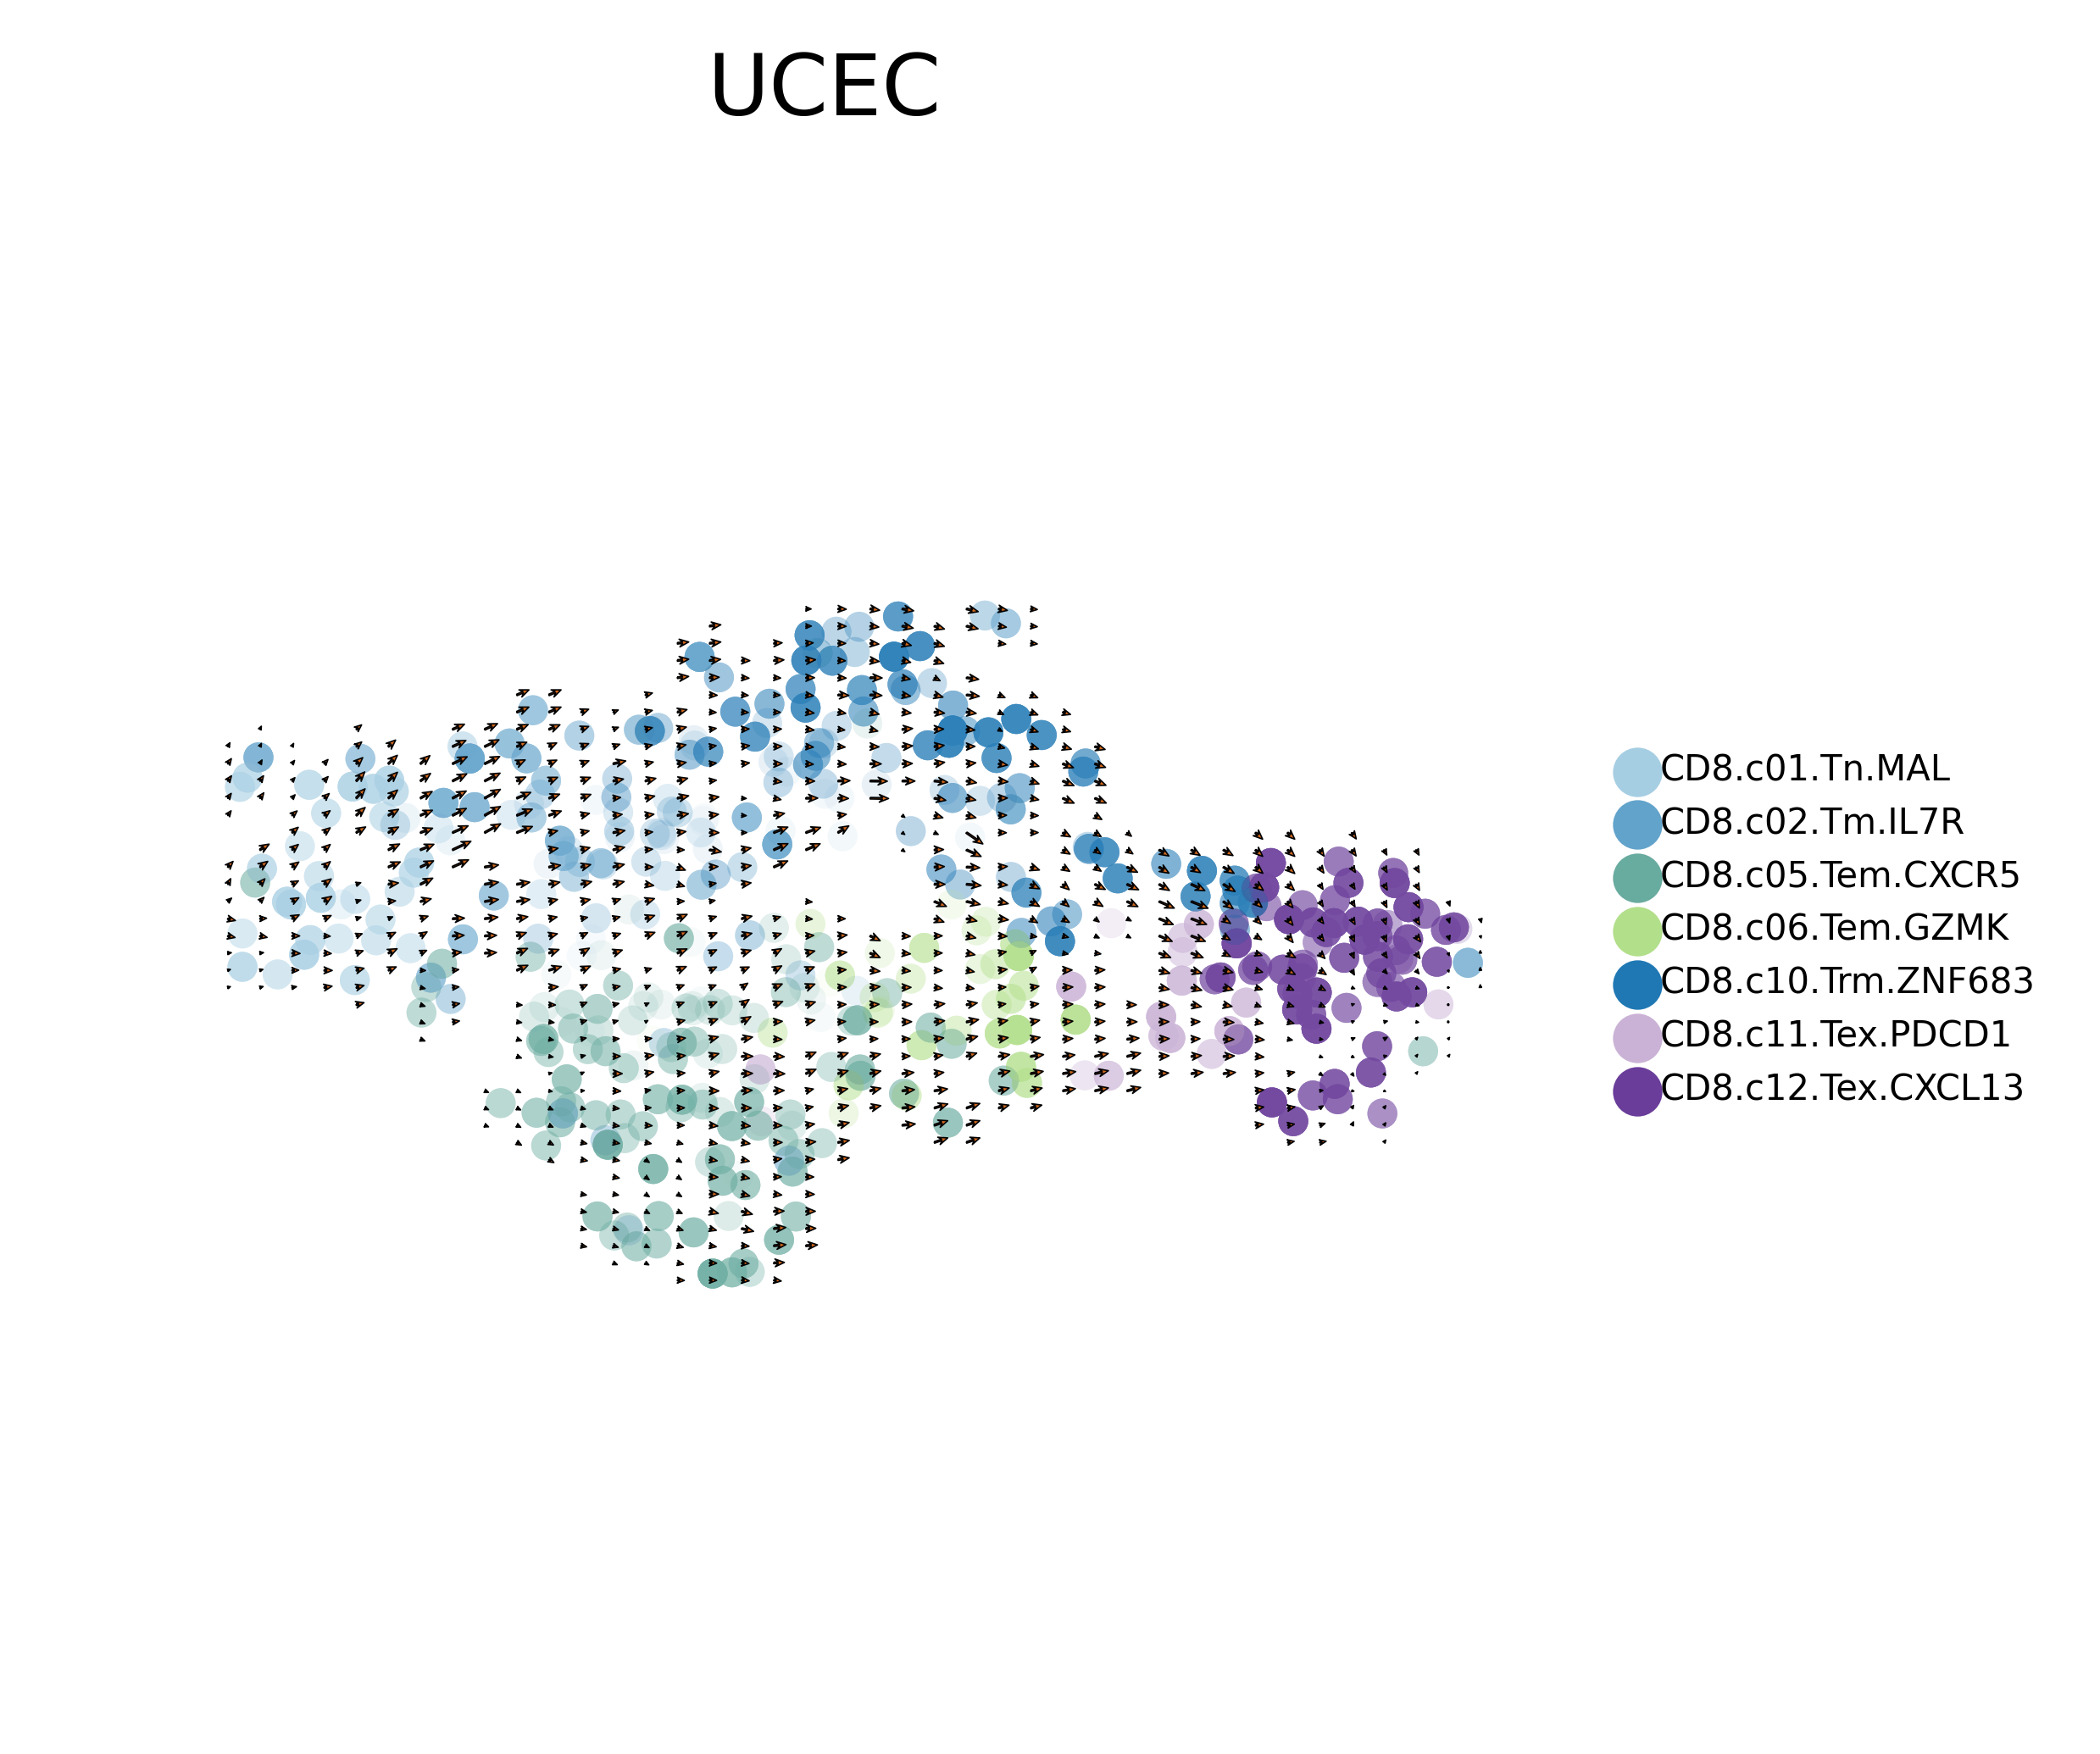

saving figure to file ./figures/scvelo_CD8_Tex.FigureS14.PACA.pdf


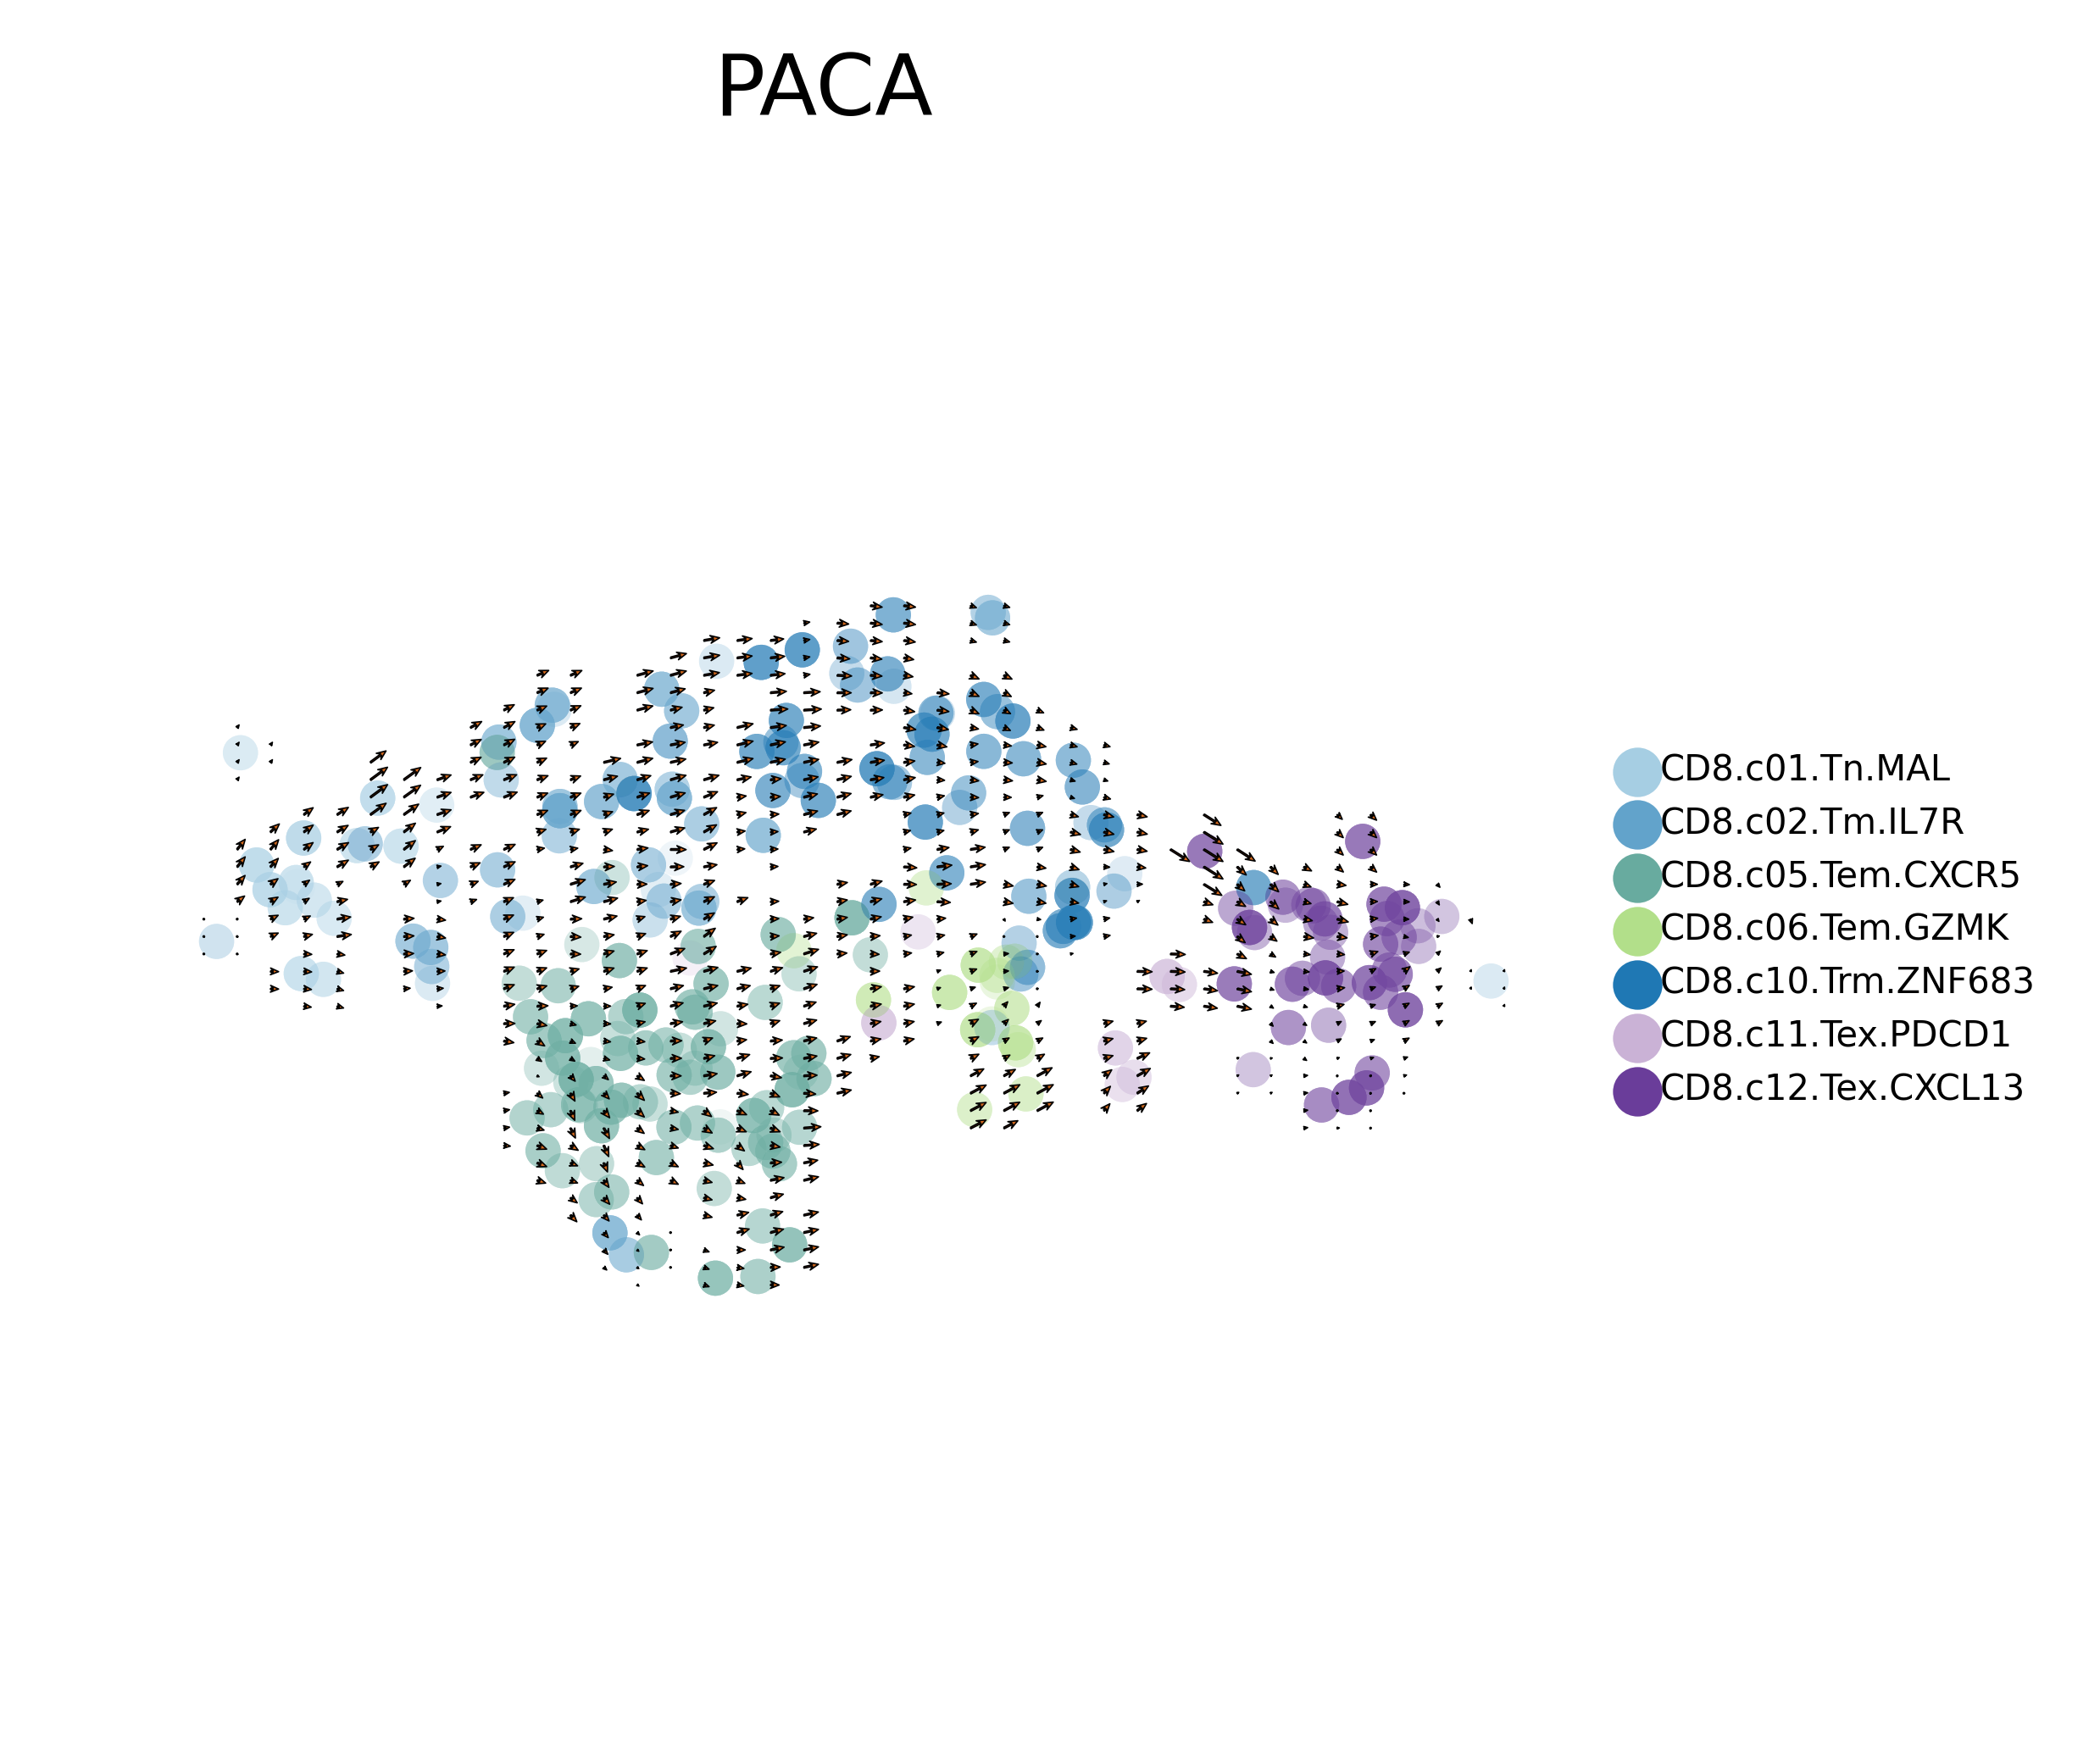

saving figure to file ./figures/scvelo_CD8_Tex.FigureS14.THCA.pdf


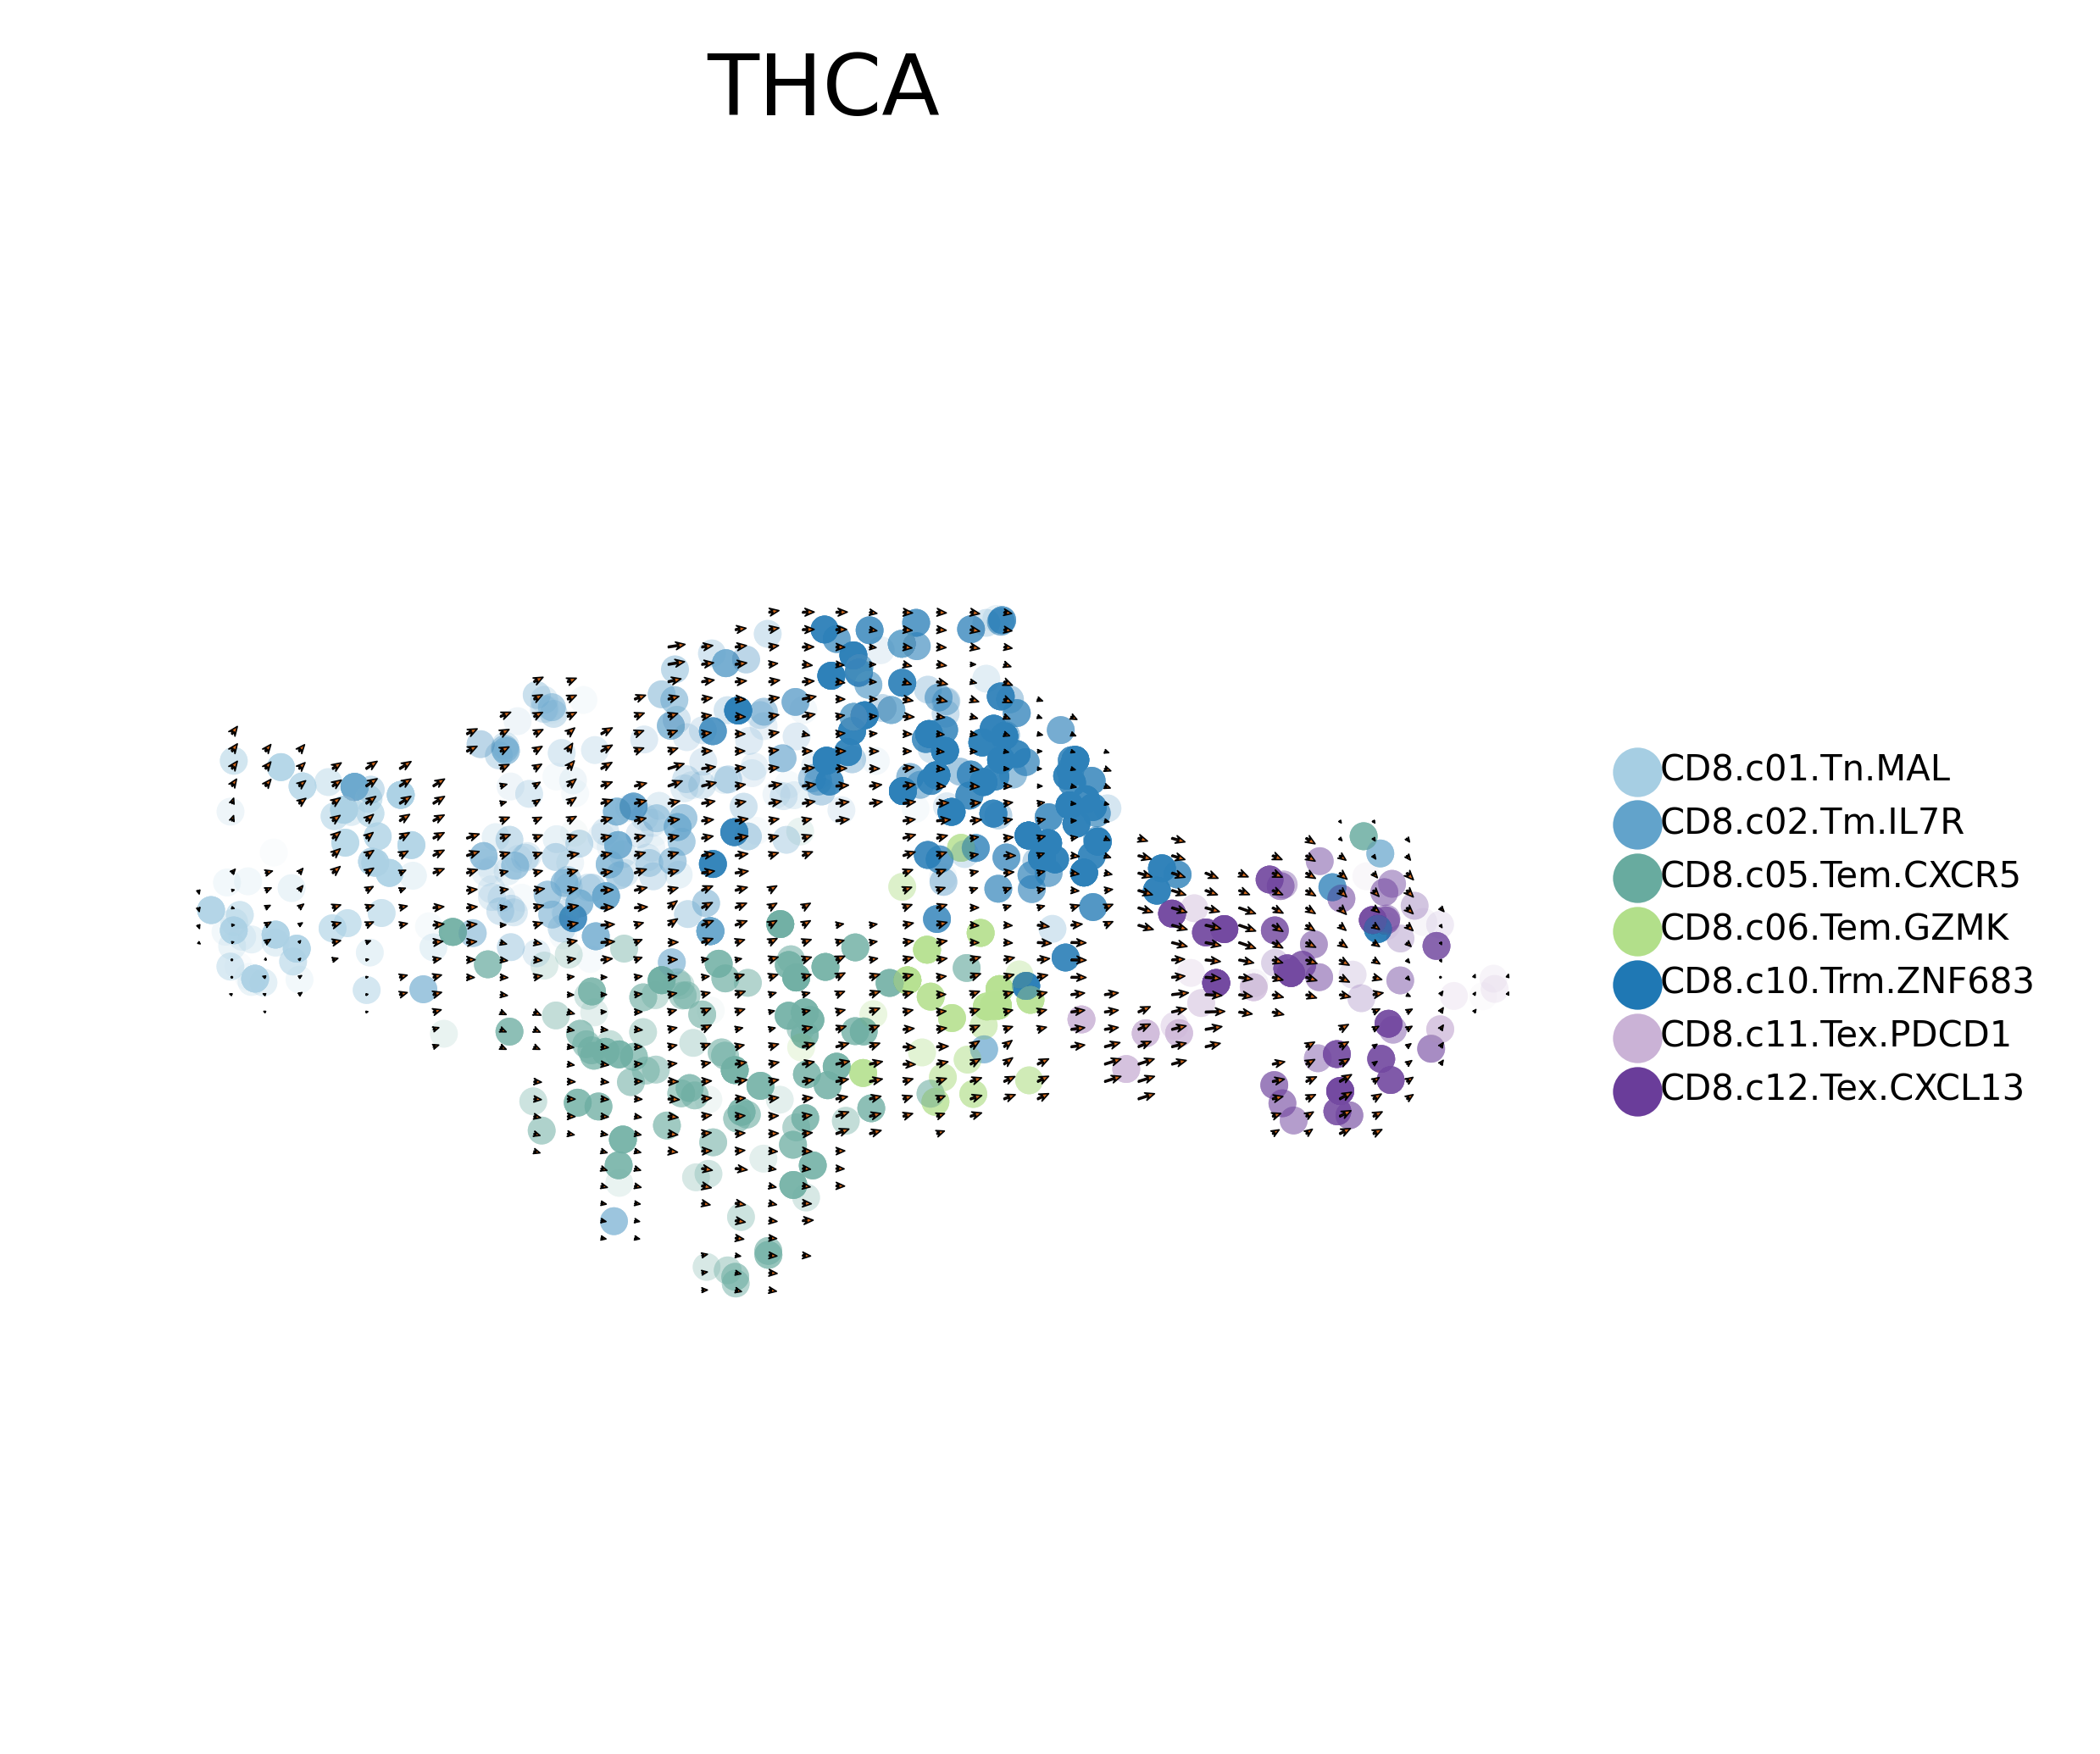

saving figure to file ./figures/scvelo_CD8_Tex.FigureS14.ESCA.pdf


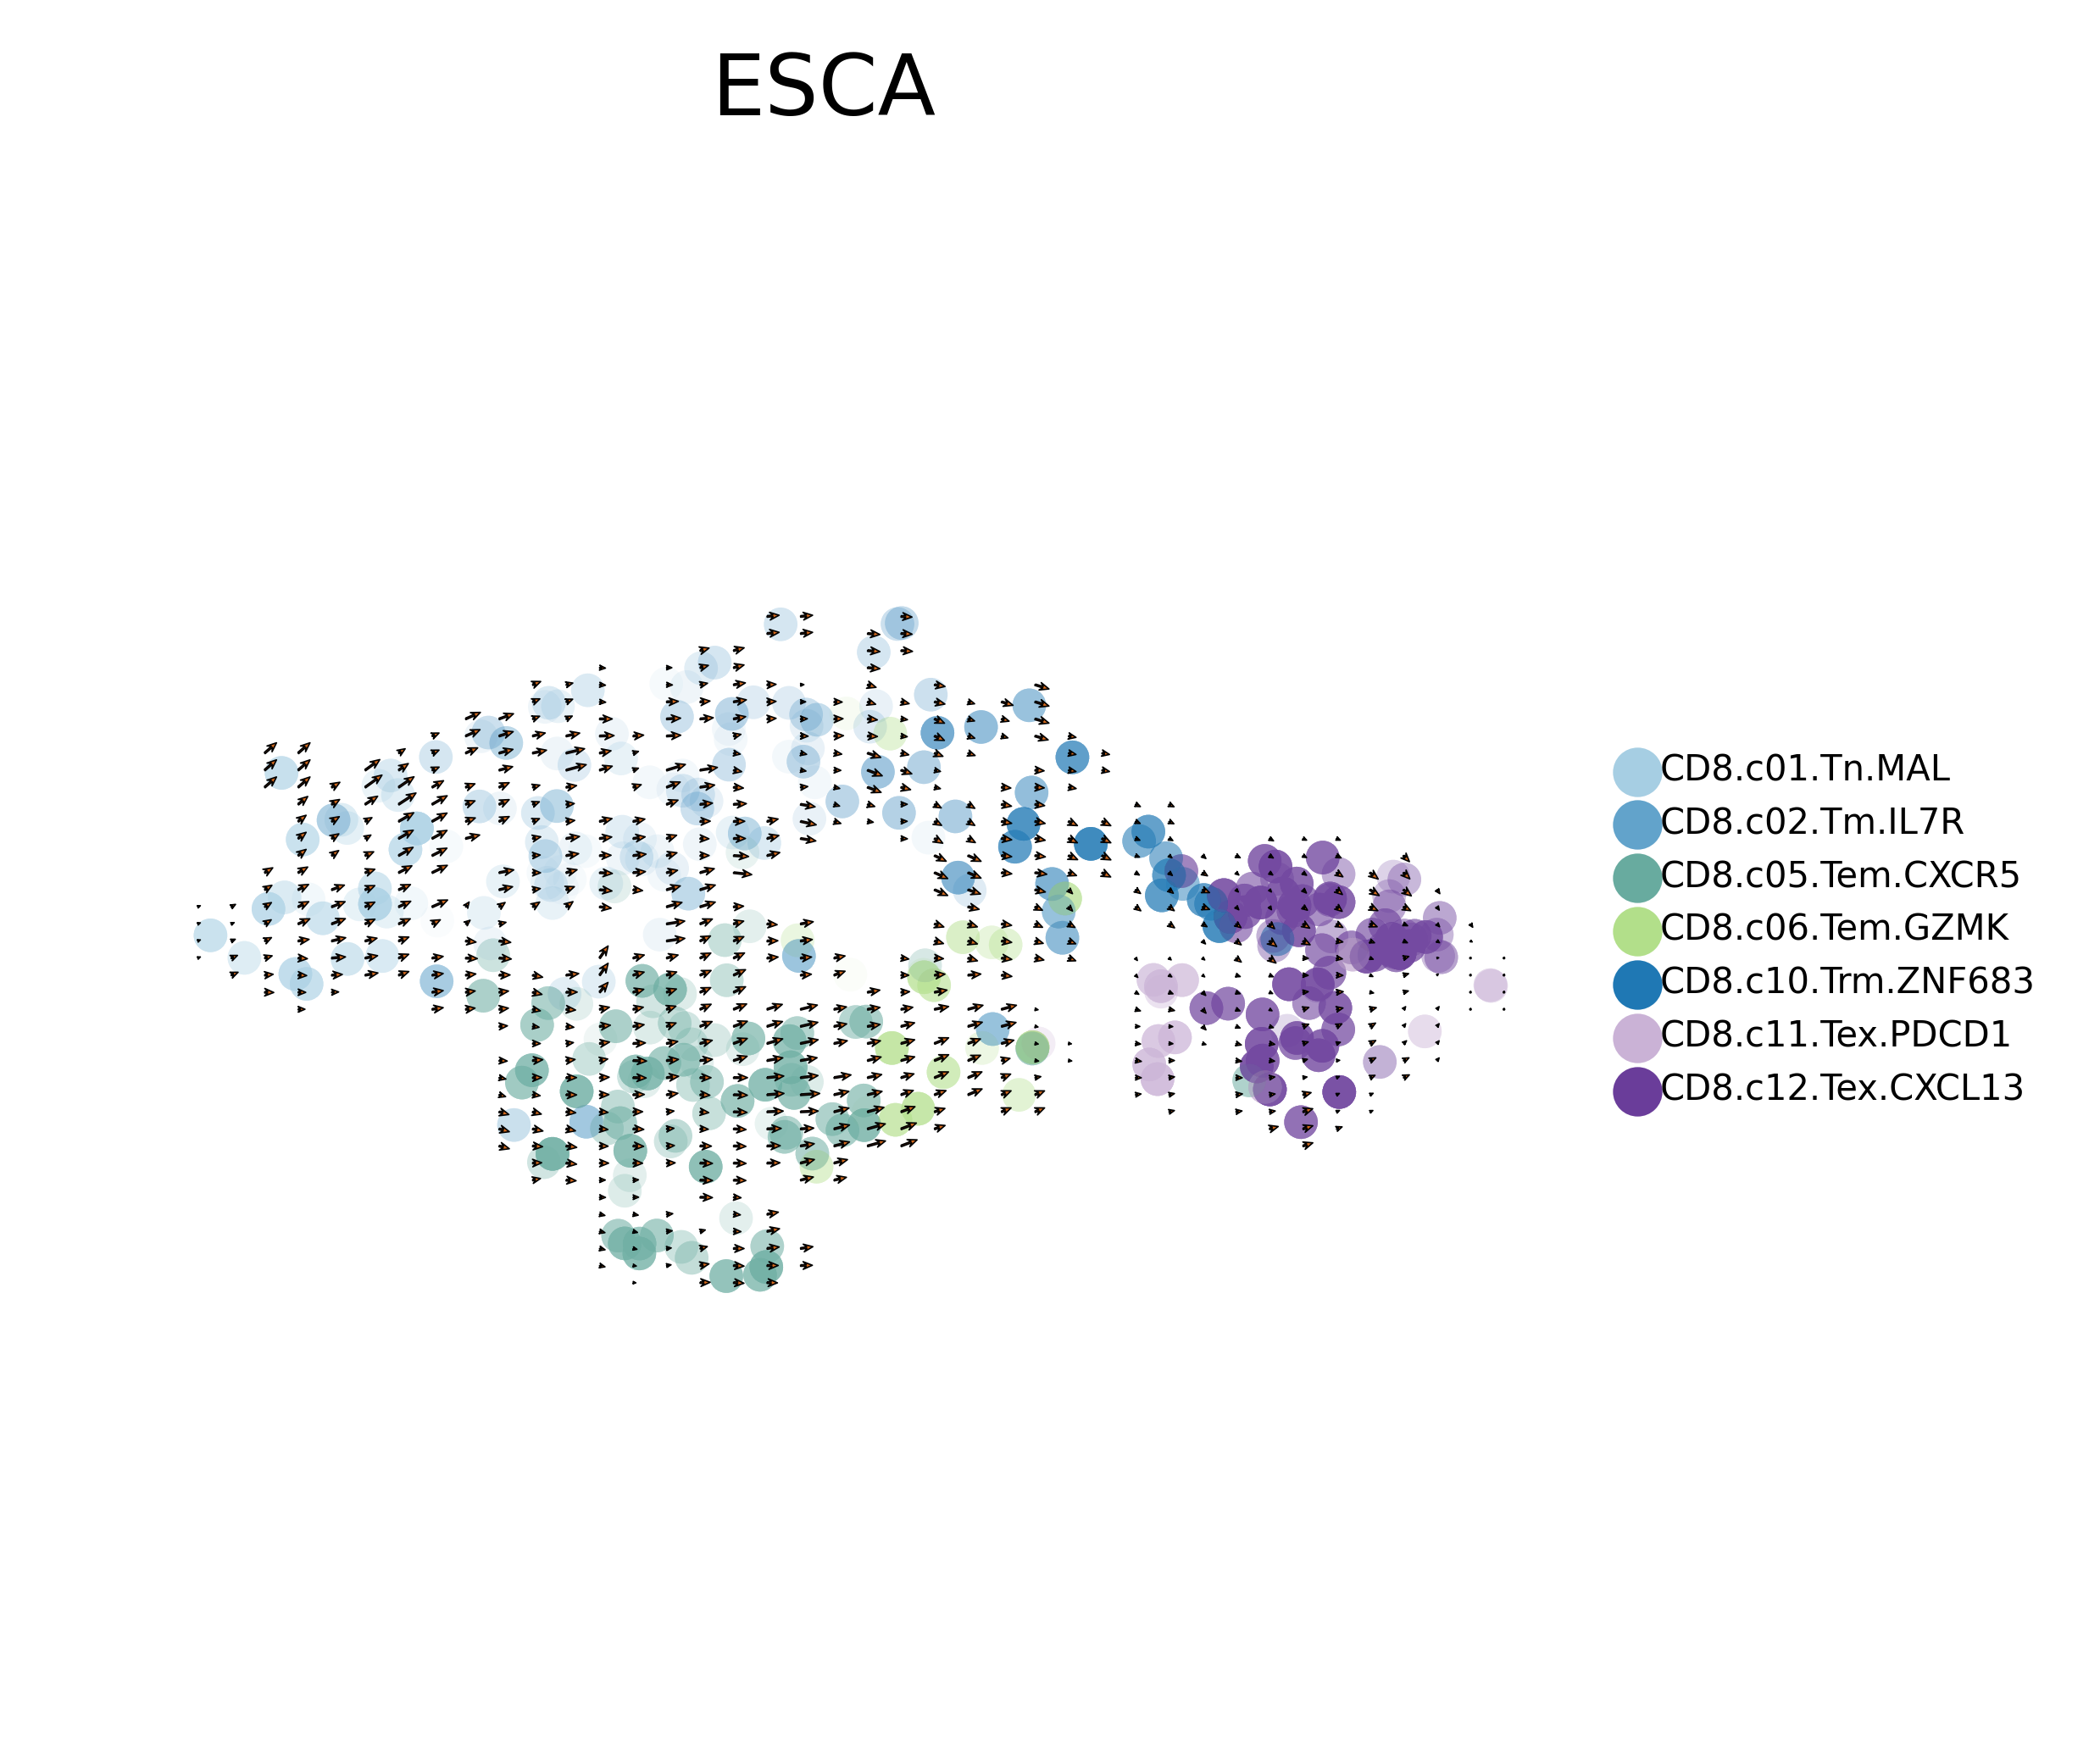

In [16]:
# for each cancerType (only T)
for i in ['UCEC','PACA','THCA','ESCA']:
    flag = [j == i for j in adata.obs.loc[:,'cancerType']]
    adata_sub = adata[flag,]
    flag2 = [j == "T" for j in adata_sub.obs.loc[:,'loc']]
    adata_sub = adata_sub[flag2,]
    #
    scv.settings.set_figure_params('scvelo', dpi=300, dpi_save=300)
    fig, ax = plt.subplots()
    ax.set_aspect(1)
    scv.pl.velocity_embedding_grid(adata_sub, basis='UMAP',color='meta.cluster', title=i,
                               arrow_size=1, arrow_length=2, arrow_color="#D2691E", alpha=0.05,
                               legend_loc='right margin',legend_fontsize=5,
                               density=0.8,
                               save=f"{stype}_Tex.FigureS14.{i}.pdf",# figsize=(10,9),
                               xlim=[-10,10],ylim=[-10,10], ax=ax)

saving figure to file ./figures/scvelo_CD8_Tex.FigureS14.UCEC.P20190312.pdf


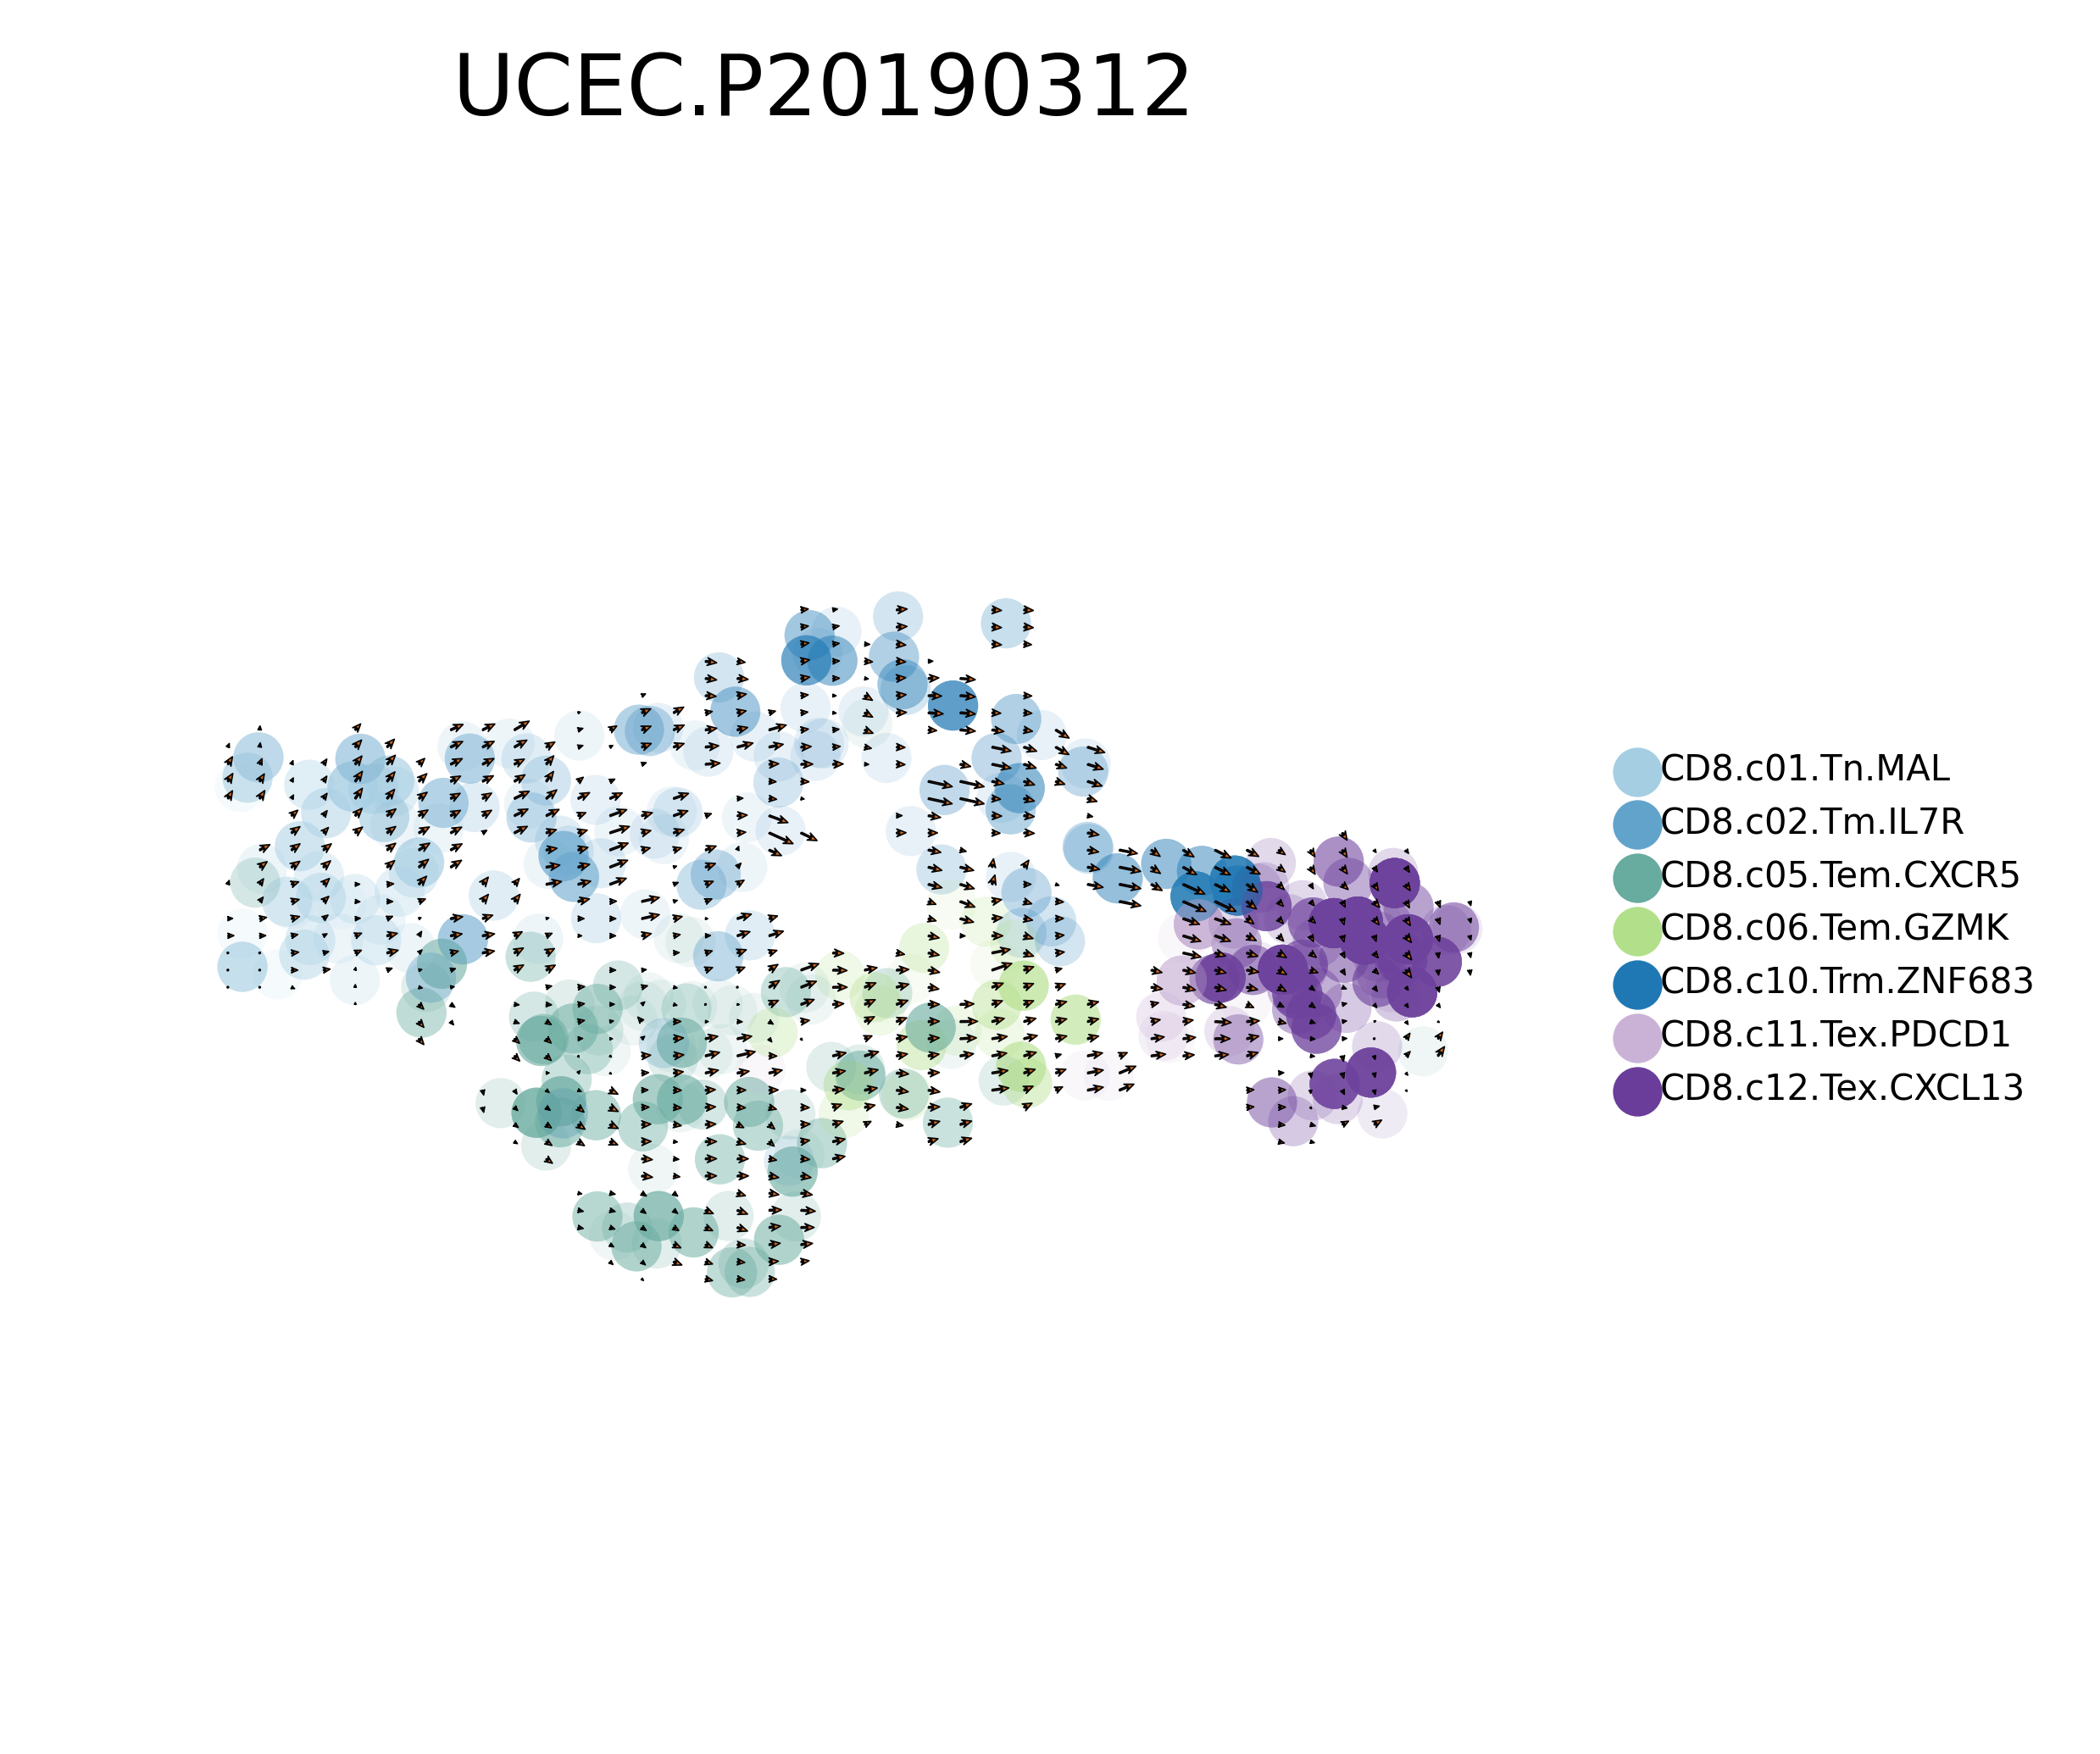

saving figure to file ./figures/scvelo_CD8_Tex.FigureS14.UCEC.P20190213.pdf


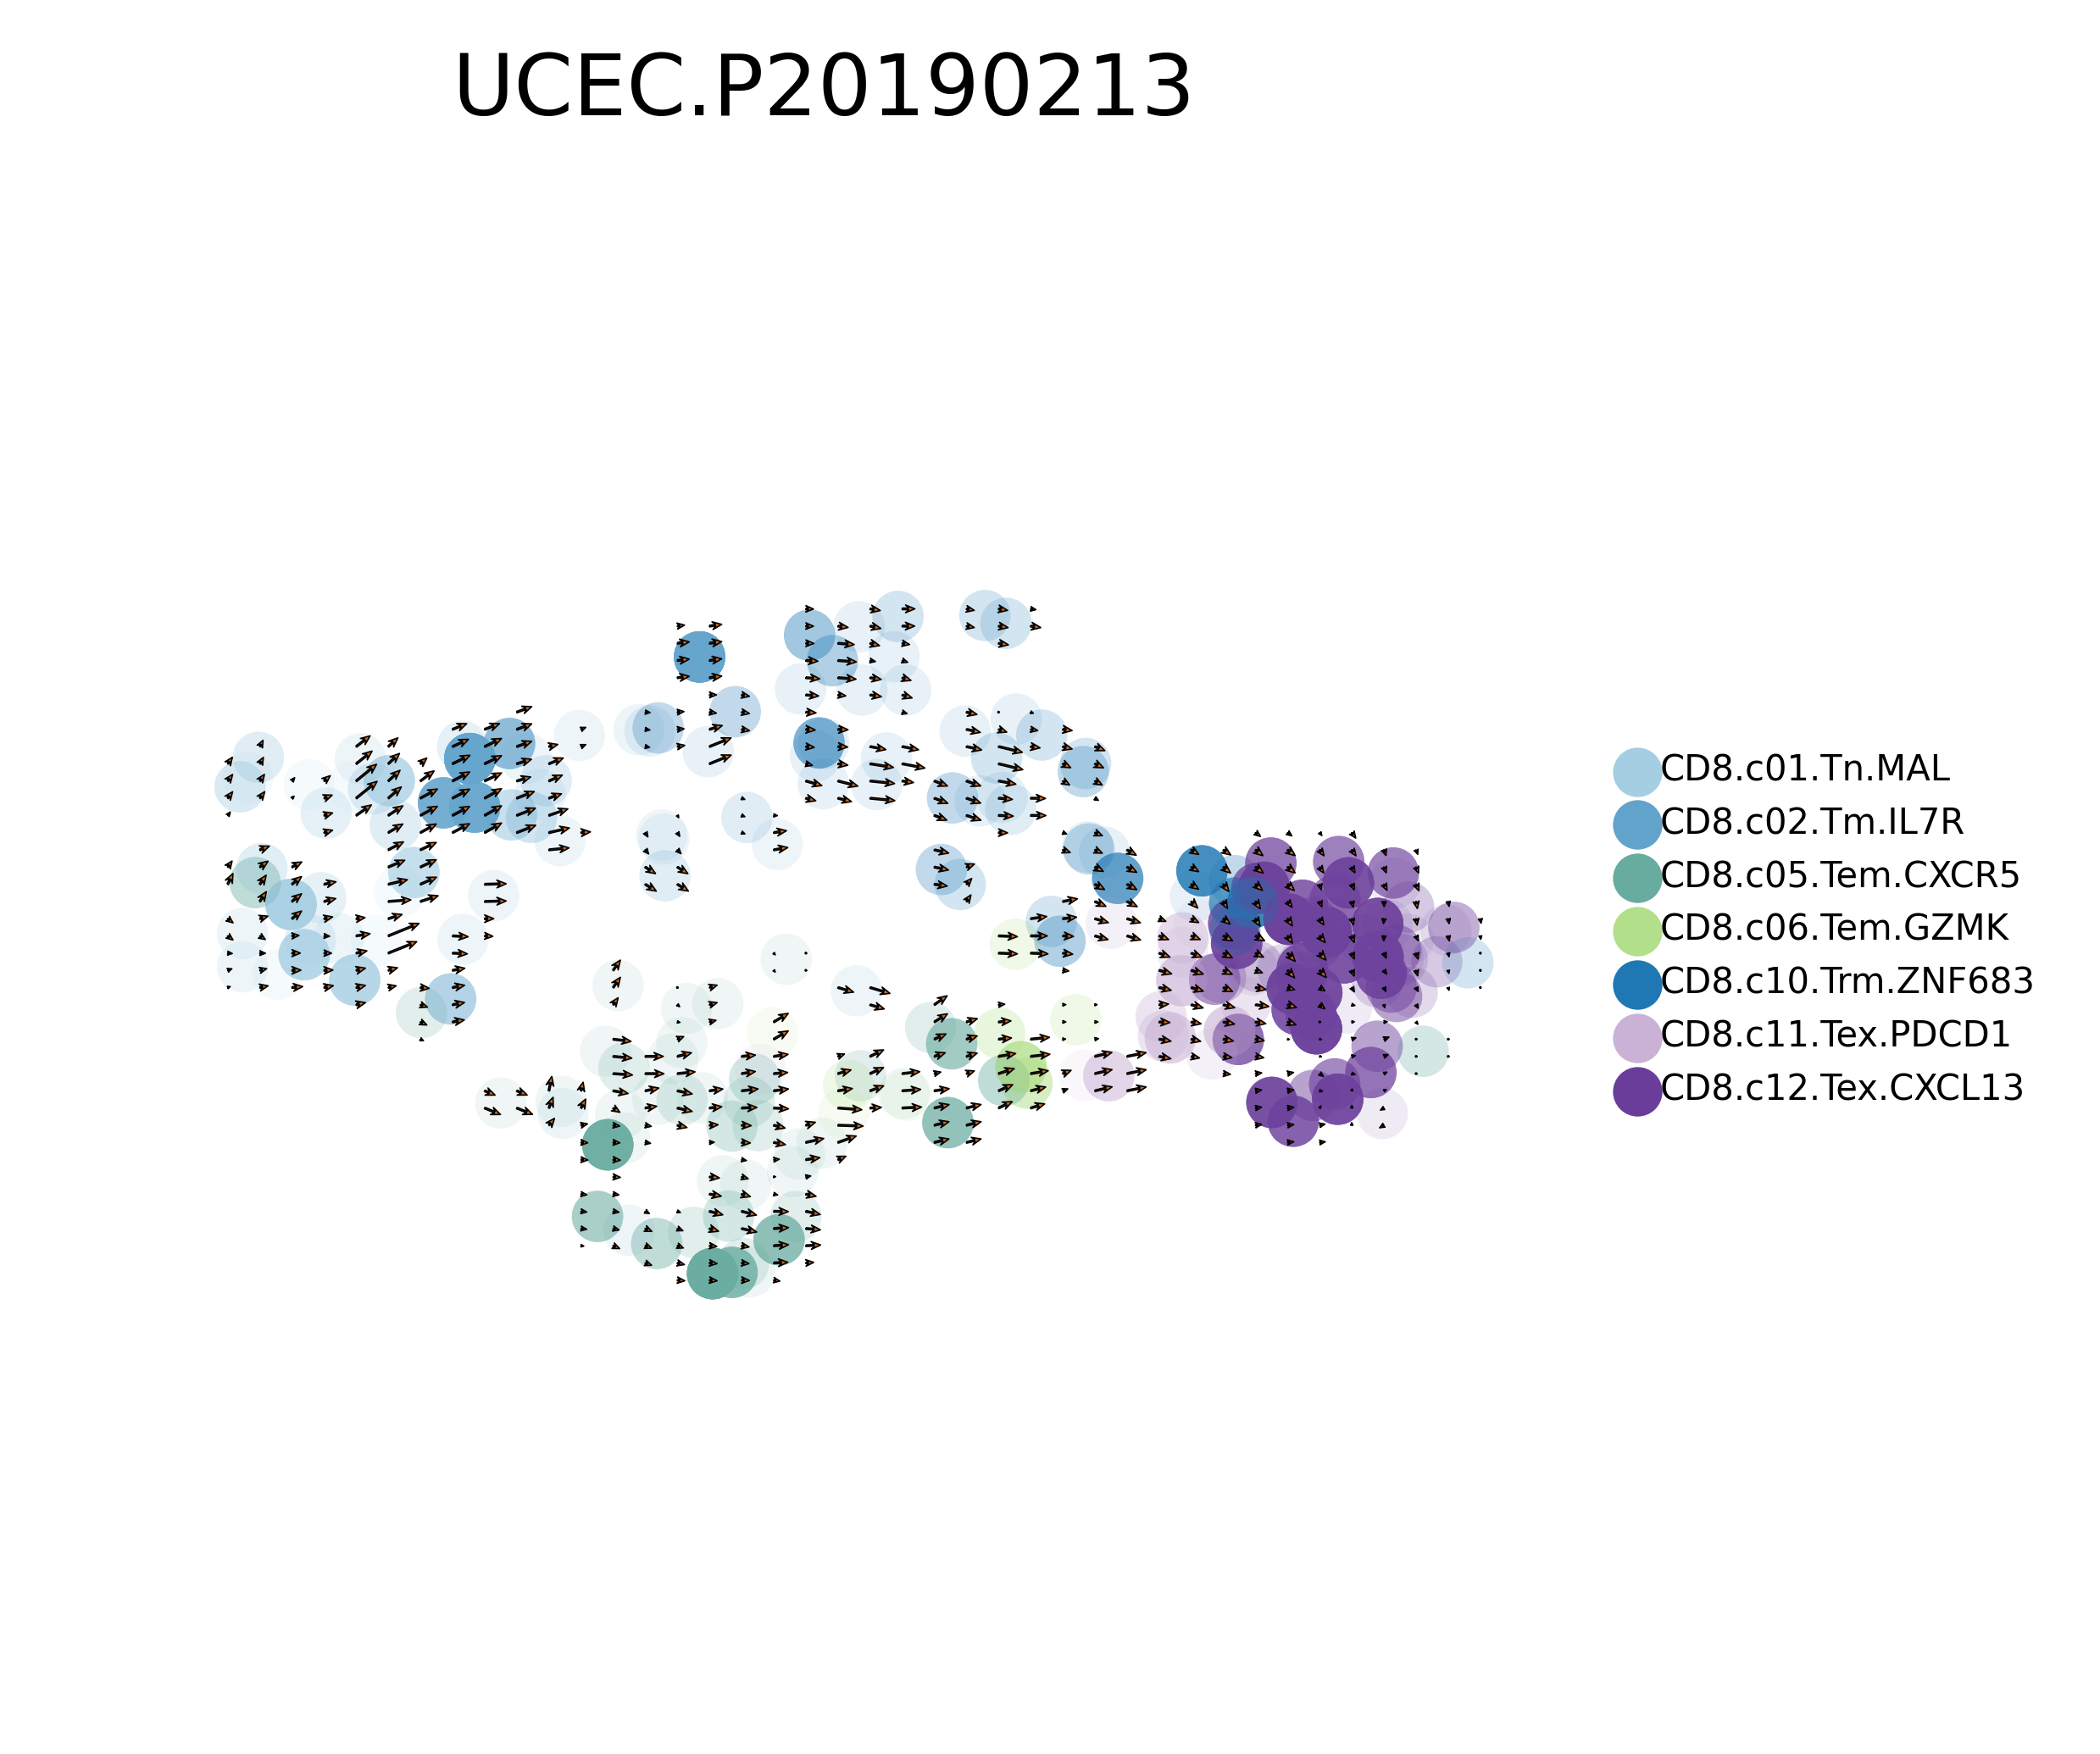

saving figure to file ./figures/scvelo_CD8_Tex.FigureS14.UCEC.P20190305.pdf


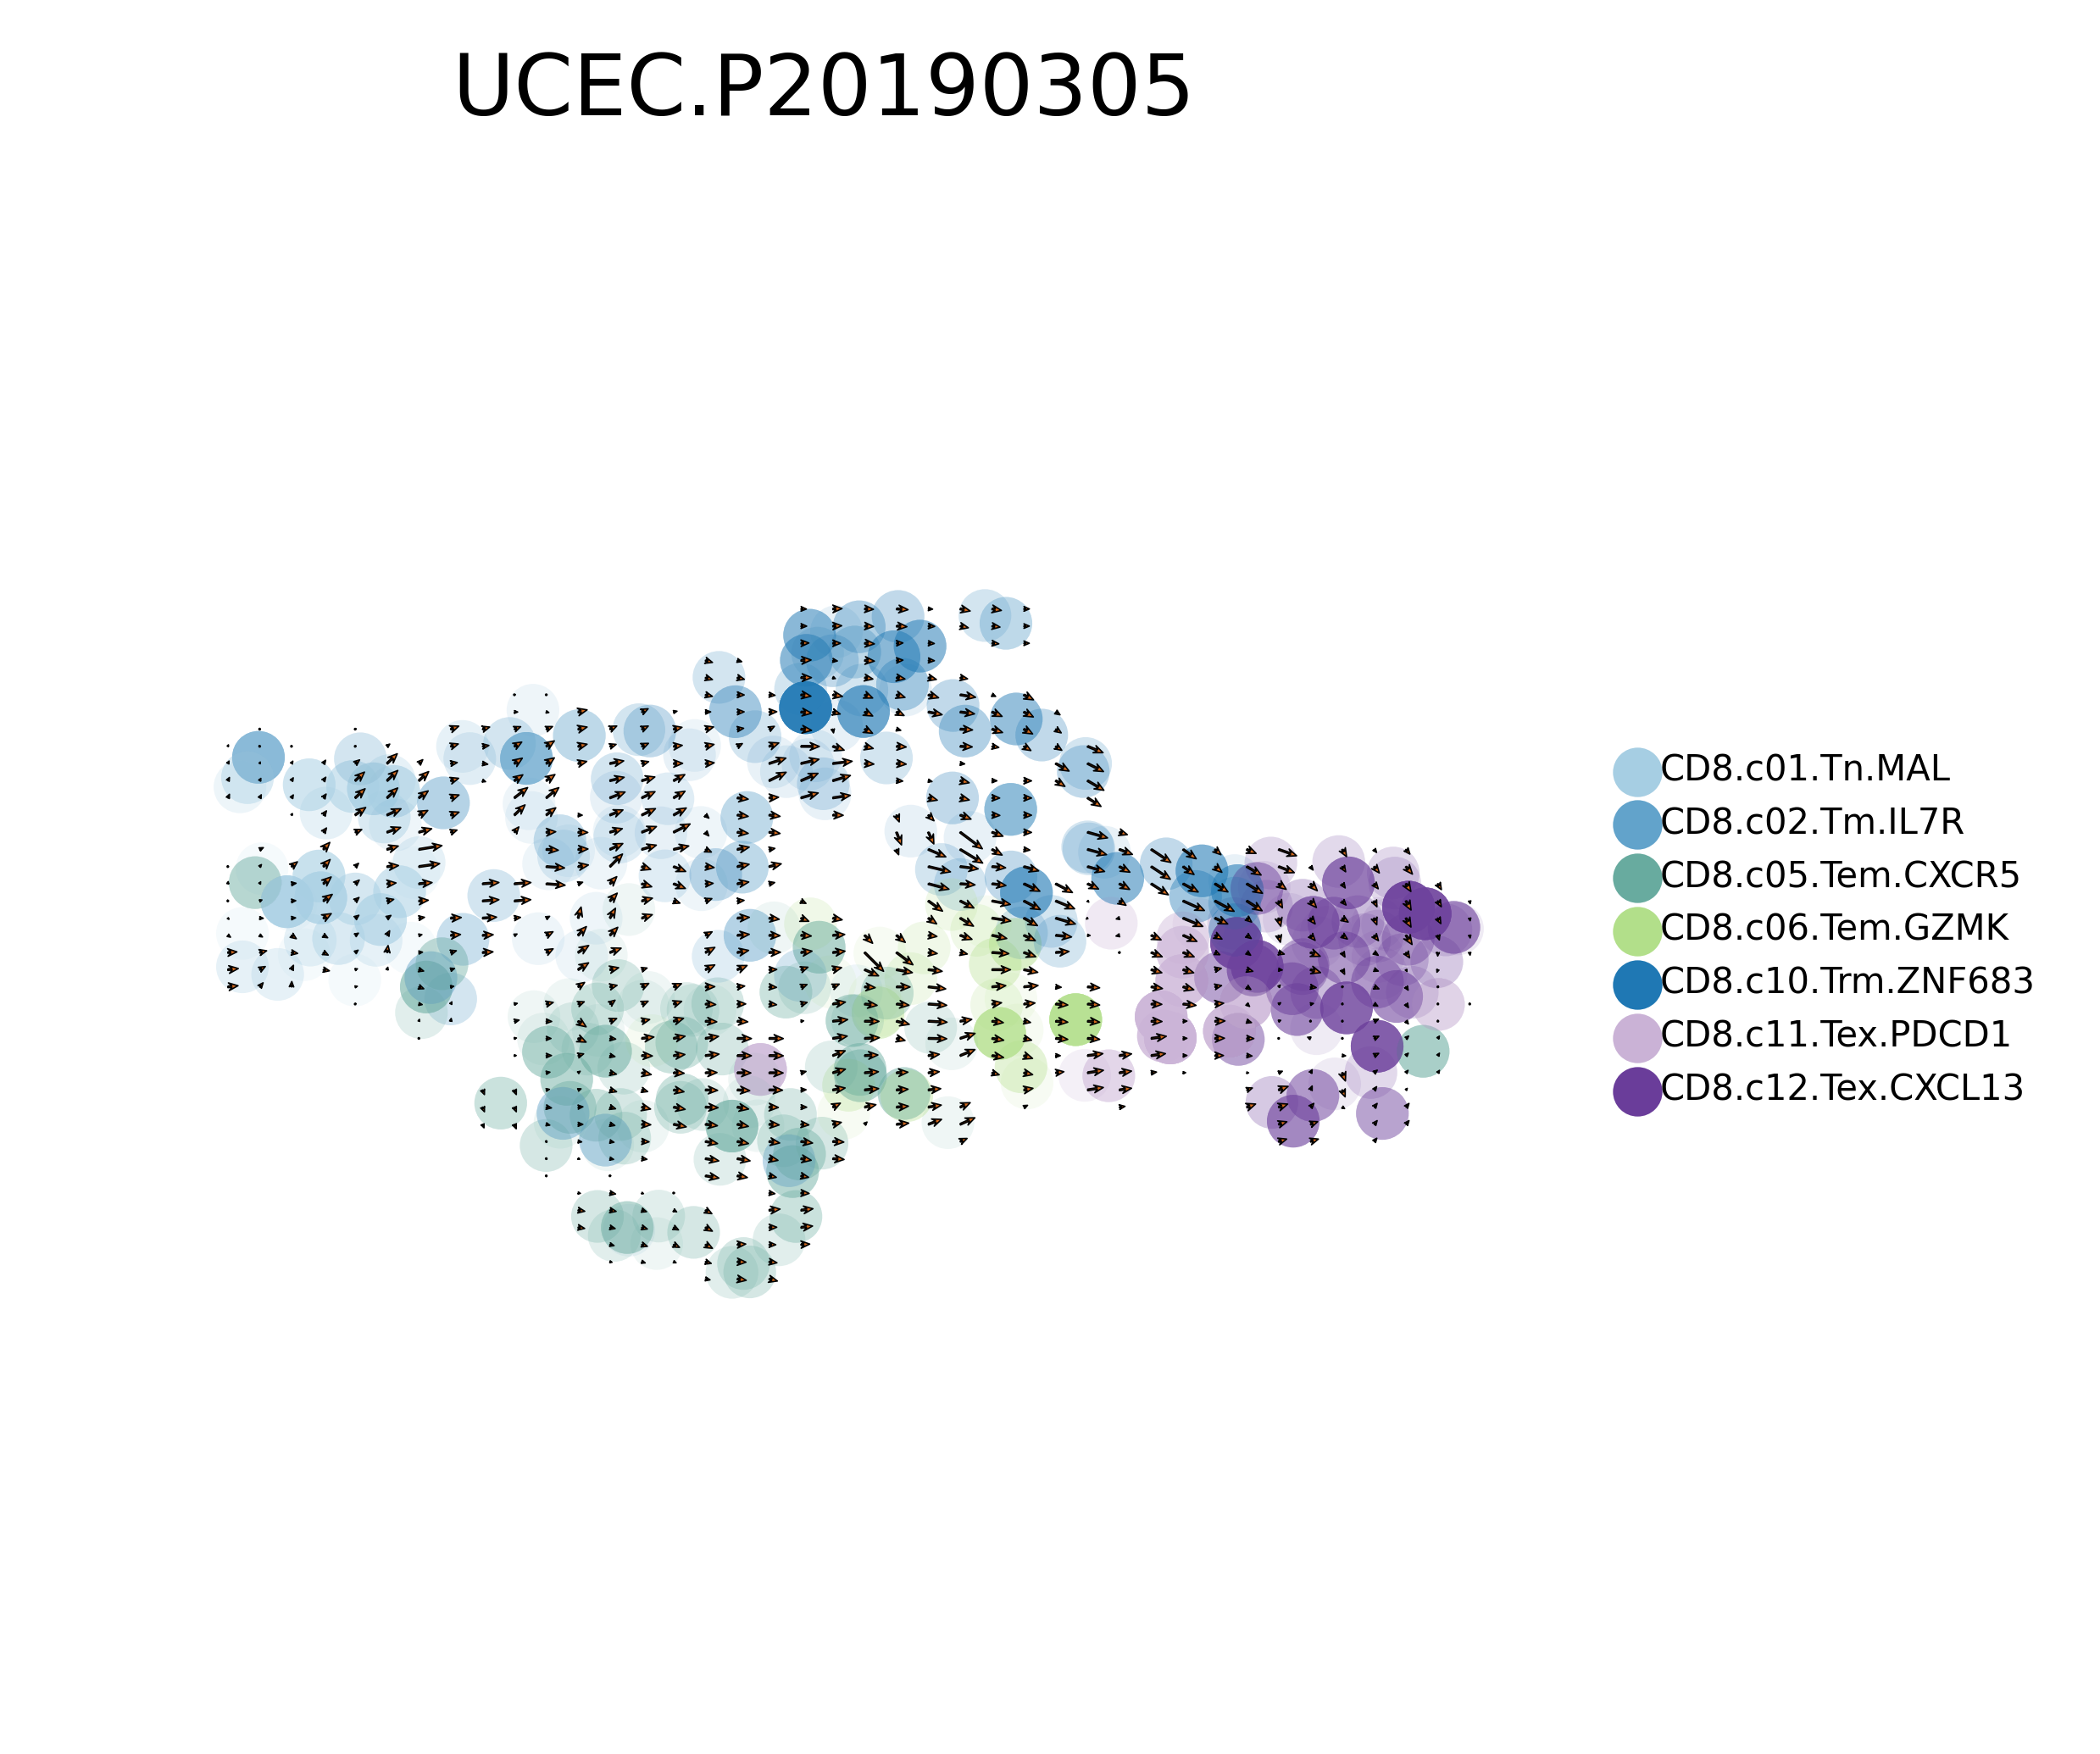

In [17]:
# for each patients (only T)
patients = [
            'UCEC.P20190312','UCEC.P20190213','UCEC.P20190305'
            #,'THCA.P20190108', 'THCA.P20181226','THCA.P20190118'
            #,'PACA.P20181128','MM.P20190122','OV.P20190304'
           ]
for i in patients:
    flag = [j == i for j in adata.obs.loc[:,'patient']]
    adata_sub = adata[flag,]
    flag2 = [j == "T" for j in adata_sub.obs.loc[:,'loc']]
    adata_sub = adata_sub[flag2,]
    #
    scv.settings.set_figure_params('scvelo', dpi=300, dpi_save=300)
    fig, ax = plt.subplots()
    ax.set_aspect(1)
    scv.pl.velocity_embedding_grid(adata_sub, basis='UMAP',color='meta.cluster', title=i,
                               arrow_size=1, arrow_length=2, arrow_color="#D2691E", alpha=0.1, density=0.8,
                               legend_loc='right margin',legend_fontsize=5,
                               save=f"{stype}_Tex.FigureS14.{i}.pdf", #figsize=(10,9),
                                  xlim=[-10,10],ylim=[-10,10], ax=ax)